### Bayesian Neural Networks

Mihai Matei [Data Science]

#### Module dependencies
Please make sure you have all the dependencies installed. On some platforms pip install might fail.
* randomcolor is used to generate color for plots
* tensorflow-gpu and tensorflow-probability are used to build the Bayesian NN
* arviz is a multi-backend Bayesian diagnosis and plotting library

All API calls that start with **mm** come from my own library implemented for the Practical Machine Learning course (check source directory).

The Bayesian Neural Network is implemented with Tensorflow Probability only (no Edward2, no PYMC). It then uses MAP, MCMC and VI to train the network

In [1]:
# Download some of the required libraries
import sys
def install_modules():
    """Depending on your platform you might consider installing the below manually"""
    !pip install --quiet numpy
    !pip install --quiet matplotlib
    !pip install --quiet randomcolor
    !pip install --quiet Pillow
    !pip install --quiet pandas
    !pip install --quiet scikit-learn
    !pip install --quiet tensorflow-gpu
    !pip install --quiet tensorflow-probability
    !pip install --quiet arviz
install_modules()

# My own library for ML
import matmih as mm
_M = {}

#### Download the IRIS dataset

There are three classes, Setosa class is linearly separable from the other two classes. Versicolor and Virginica classes are not linearly separable. 


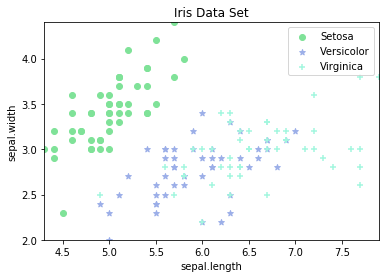

In [2]:
%reload_ext autoreload
%autoreload
from sklearn import datasets
import pandas as pd

# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/ProgProb/BayesNN/'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)

# load iris dataset
iris = datasets.load_iris()
pDF = pd.DataFrame(iris.data, columns=['sepal.length', 'sepal.width', 'petal.length', 'petal.width'])
pDF['target'] = iris.target
pDF['target'] = pDF['target'].astype('category')
pDF['target'] = pDF['target'].cat.rename_categories({0 : 'Setosa', 1 : 'Versicolor', 2 : 'Virginica'})
pDF.dropna(how="all", inplace=True)

setosa = pDF[pDF['target']=='Setosa']
versicolor = pDF[pDF['target']=='Versicolor']
virginica = pDF[pDF['target']=='Virginica']
mm.PlotBuilder().create_scatter_plot('Iris Data Set', ('sepal.length', 'sepal.width'),
                                     (setosa['sepal.length'], setosa['sepal.width'], 'Setosa'),
                                     (versicolor['sepal.length'], versicolor['sepal.width'], 'Versicolor'),
                                     (virginica['sepal.length'], virginica['sepal.width'], 'Virginica')).show()
del(setosa)
del(versicolor)
del(virginica)

### Data model creation
Create the binary classification dataset by removing the liniar separable Setosa class

Do a statified data split of the 2 resulting data sets.

For the training set we take a lower amount of data in order to illustrate bayesian neural network better accuracy results on smaller traing data.

The histogram of the training samples are also plotted.


==============Binary class data set==============
Train size: 65
Validation size: 25
Test size: 10


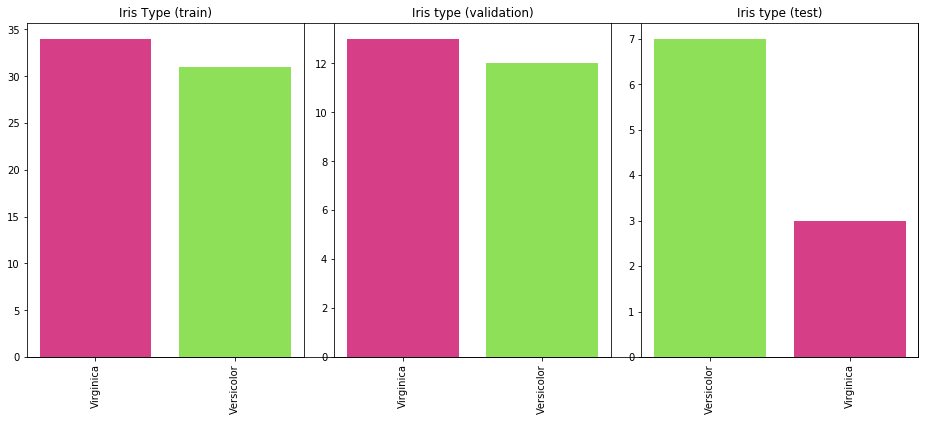

==============Multi class data set==============
Train size: 97
Validation size: 38
Test size: 15


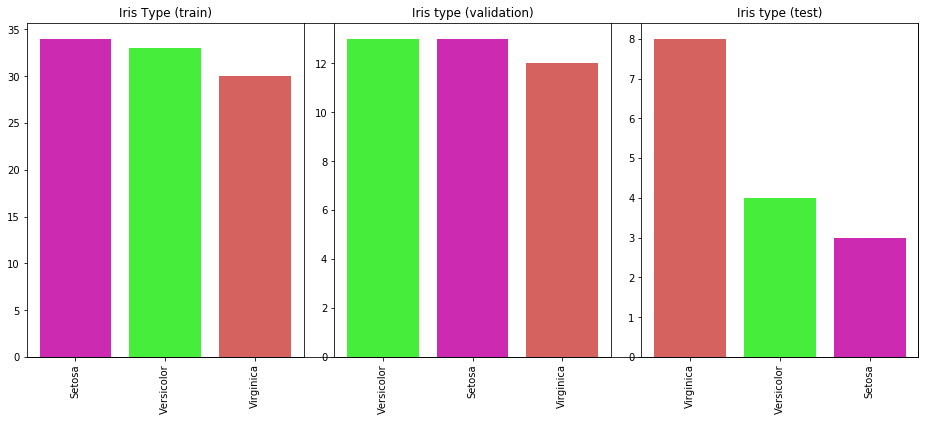

In [3]:
import numpy as np

pDF['features'] = pDF.apply(lambda row: np.array([row['sepal.length'], row['sepal.width'],
                                                  row['petal.length'], row['petal.width']]), axis=1)

pDF_2 = pDF[pDF['target'] != 'Setosa'].copy().reset_index(drop=True)
pDF_2['target'] = pDF_2['target'].astype(str).astype('category')

# Create the dataset from the panda dataframe that will be used to create the test-validation split
data_set = mm.DataSet(pDF, feature_column='features', target_column='target')
data_set_2 = mm.DataSet(pDF_2, feature_column='features', target_column='target')

# Split and shuffle the data set so that the class distribution of the pokemons remain the same - stratisfied split
data_set.split_data((0.65, 0.25, 0.1), True, True)
data_set_2.split_data((0.65, 0.25, 0.1), True, True)

print('==============Binary class data set==============')
print("Train size: {}".format(len(data_set_2.train_target)))
print("Validation size: {}".format(len(data_set_2.validation_target)))
print("Test size: {}".format(len(data_set_2.test_target)))
mm.PlotBuilder().create_histograms([data_set_2.train_target, data_set_2.validation_target, data_set_2.test_target],
                                   ['Iris Type (train)', 'Iris type (validation)', 'Iris type (test)']).show()

print('==============Multi class data set==============')
print("Train size: {}".format(len(data_set.train_target)))
print("Validation size: {}".format(len(data_set.validation_target)))
print("Test size: {}".format(len(data_set.test_target)))
mm.PlotBuilder().create_histograms([data_set.train_target, data_set.validation_target, data_set.test_target],
                                   ['Iris Type (train)', 'Iris type (validation)', 'Iris type (test)']).show()

# Create the numpy dataset that we will use in the mm.Model classes
data_model = mm.ModelDataSet(data_set)
data_model_2 = mm.ModelDataSet(data_set_2)

#### Regular Keras NN model
Implemented a keras model using 2 hidden layers with 5 nodes and relu activation and a last layer with either 2 (for binary classification) or 3 nodes with a sigmoid or softmax activation.

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

class NNModel(mm.TensorModel):
    #_base_model.summary()
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        no_classes = hyper_params.get('noClasses', len(data_model.classes))
        if no_classes == 2:
            no_classes = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hyper_params.get('denseSize', 10), input_shape=(hyper_params.get('noFeatures', 4),)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Dense(hyper_params.get('denseSize', 10)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Dense(no_classes),
            tf.keras.layers.Activation('softmax', name='softmax')
               if no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ])
        super(NNModel, self).__init__(model, checkpoint=False)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy' if no_classes > 1 else 'binary_crossentropy',
             metrics=['accuracy'])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        callbacks = []
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = NNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = NNModel.np_to_tf(data_model.validation_features, data_model.validation_target)

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  epochs=self._train_epochs, callbacks=callbacks)

        return history.history.copy()

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

# Print the summary of the model used for multiclass classification
NNModel(noFeatures=4, noClasses=3, denseSize=5)._model.summary()

Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 25        
_________________________________________________________________
batch_normalization (BatchNo (None, 5)                 20        
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5)                 20        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (Non

#### Hyperparameter lookup for the NN model
Do a hyper parameter lookup for the 2 models (binary and multiclass classification).

Take the model with the largest validation accuracy as the best model.

In [5]:
# Search the hyperparameter space for the best model for the binary classifier
nnHyperLookup_2 = mm.HyperParamsLookup(NNModel(), lambda hist: np.max(hist['val_accuracy']))
nnHyperLookup_2.grid_search(data_model_2, True,
                            noFeatures=[4],
                            noClasses=[2],
                            trainEpochs=[100],
                            denseSize=[5],
                            optimizer=[tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                       tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True),
                                       tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)] )

# Search the hyperparameter space for the best model for the multiclass classifier
nnHyperLookup = mm.HyperParamsLookup(NNModel(), lambda hist: np.max(hist['val_accuracy']))
nnHyperLookup.grid_search(data_model, True,
                          noFeatures=[4],
                          noClasses=[3],
                          trainEpochs=[100],
                          denseSize=[5],
                          optimizer=[tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                     tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True),
                                     tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)] )

Epoch 1/100
3/3 [==============================] - 2s 740ms/step - loss: 0.9211 - accuracy: 0.2769 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 68ms/step - loss: 1.0095 - accuracy: 0.2769 - val_loss: 0.6500 - val_accuracy: 0.5200
Epoch 3/100
3/3 [==============================] - 0s 68ms/step - loss: 0.9921 - accuracy: 0.2923 - val_loss: 0.6469 - val_accuracy: 0.5200
Epoch 4/100
3/3 [==============================] - 0s 70ms/step - loss: 0.9778 - accuracy: 0.2923 - val_loss: 0.6440 - val_accuracy: 0.5200
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.9647 - accuracy: 0.3077 - val_loss: 0.6409 - val_accuracy: 0.5200
Epoch 6/100
3/3 [==============================] - 0s 68ms/step - loss: 0.9524 - accuracy: 0.3231 - val_loss: 0.6378 - val_accuracy: 0.5600
Epoch 7/100
3/3 [==============================] - 0s 69ms/step - loss: 0.9406 - accuracy: 0.3231 - val_loss: 0.6347 - val_accuracy: 0.5600
Epoch 8/100

3/3 [==============================] - 0s 72ms/step - loss: 0.4788 - accuracy: 0.7846 - val_loss: 0.8018 - val_accuracy: 0.5200
Epoch 60/100
3/3 [==============================] - 0s 67ms/step - loss: 0.4755 - accuracy: 0.7846 - val_loss: 0.7799 - val_accuracy: 0.5200
Epoch 61/100
3/3 [==============================] - 0s 71ms/step - loss: 0.4721 - accuracy: 0.8000 - val_loss: 0.7771 - val_accuracy: 0.5200
Epoch 62/100
3/3 [==============================] - 0s 68ms/step - loss: 0.4687 - accuracy: 0.8462 - val_loss: 0.7727 - val_accuracy: 0.5200
Epoch 63/100
3/3 [==============================] - 0s 74ms/step - loss: 0.4656 - accuracy: 0.8769 - val_loss: 0.7701 - val_accuracy: 0.5200
Epoch 64/100
3/3 [==============================] - 0s 72ms/step - loss: 0.4623 - accuracy: 0.8769 - val_loss: 0.7655 - val_accuracy: 0.5200
Epoch 65/100
3/3 [==============================] - 0s 69ms/step - loss: 0.4592 - accuracy: 0.8769 - val_loss: 0.7660 - val_accuracy: 0.5200
Epoch 66/100
3/3 [========

3/3 [==============================] - 0s 72ms/step - loss: 0.4888 - accuracy: 0.6769 - val_loss: 1.0154 - val_accuracy: 0.5200
Epoch 16/100
3/3 [==============================] - 0s 71ms/step - loss: 0.4866 - accuracy: 0.6769 - val_loss: 1.0131 - val_accuracy: 0.5200
Epoch 17/100
3/3 [==============================] - 0s 82ms/step - loss: 0.4846 - accuracy: 0.6769 - val_loss: 1.0106 - val_accuracy: 0.5200
Epoch 18/100
3/3 [==============================] - 0s 74ms/step - loss: 0.4826 - accuracy: 0.6923 - val_loss: 1.0077 - val_accuracy: 0.5200
Epoch 19/100
3/3 [==============================] - 0s 73ms/step - loss: 0.4806 - accuracy: 0.6923 - val_loss: 1.0048 - val_accuracy: 0.5200
Epoch 20/100
3/3 [==============================] - 0s 100ms/step - loss: 0.4786 - accuracy: 0.6923 - val_loss: 1.0012 - val_accuracy: 0.5200
Epoch 21/100
3/3 [==============================] - 0s 88ms/step - loss: 0.4769 - accuracy: 0.6923 - val_loss: 0.9972 - val_accuracy: 0.5200
Epoch 22/100
3/3 [=======

3/3 [==============================] - 0s 67ms/step - loss: 0.4261 - accuracy: 0.6923 - val_loss: 0.5574 - val_accuracy: 0.7600
Epoch 74/100
3/3 [==============================] - 0s 70ms/step - loss: 0.4255 - accuracy: 0.6923 - val_loss: 0.5488 - val_accuracy: 0.7600
Epoch 75/100
3/3 [==============================] - 0s 73ms/step - loss: 0.4250 - accuracy: 0.6923 - val_loss: 0.5418 - val_accuracy: 0.7600
Epoch 76/100
3/3 [==============================] - 0s 69ms/step - loss: 0.4244 - accuracy: 0.6923 - val_loss: 0.5339 - val_accuracy: 0.7600
Epoch 77/100
3/3 [==============================] - 0s 69ms/step - loss: 0.4238 - accuracy: 0.6923 - val_loss: 0.5267 - val_accuracy: 0.7600
Epoch 78/100
3/3 [==============================] - 0s 68ms/step - loss: 0.4232 - accuracy: 0.6923 - val_loss: 0.5177 - val_accuracy: 0.7600
Epoch 79/100
3/3 [==============================] - 0s 70ms/step - loss: 0.4227 - accuracy: 0.6923 - val_loss: 0.5108 - val_accuracy: 0.7600
Epoch 80/100
3/3 [========

3/3 [==============================] - 0s 74ms/step - loss: 0.7409 - accuracy: 0.5538 - val_loss: 0.8816 - val_accuracy: 0.5200
Epoch 30/100
3/3 [==============================] - 0s 74ms/step - loss: 0.7331 - accuracy: 0.5538 - val_loss: 0.8536 - val_accuracy: 0.5200
Epoch 31/100
3/3 [==============================] - 0s 72ms/step - loss: 0.7251 - accuracy: 0.5538 - val_loss: 0.8268 - val_accuracy: 0.5200
Epoch 32/100
3/3 [==============================] - 0s 70ms/step - loss: 0.7172 - accuracy: 0.5692 - val_loss: 0.8008 - val_accuracy: 0.5200
Epoch 33/100
3/3 [==============================] - 0s 71ms/step - loss: 0.7095 - accuracy: 0.5692 - val_loss: 0.7746 - val_accuracy: 0.5200
Epoch 34/100
3/3 [==============================] - 0s 68ms/step - loss: 0.7019 - accuracy: 0.5692 - val_loss: 0.7489 - val_accuracy: 0.5200
Epoch 35/100
3/3 [==============================] - 0s 70ms/step - loss: 0.6944 - accuracy: 0.5846 - val_loss: 0.7239 - val_accuracy: 0.5200
Epoch 36/100
3/3 [========

3/3 [==============================] - 0s 69ms/step - loss: 0.4182 - accuracy: 0.9538 - val_loss: 0.3905 - val_accuracy: 0.9200
Epoch 88/100
3/3 [==============================] - 0s 72ms/step - loss: 0.4145 - accuracy: 0.9538 - val_loss: 0.3886 - val_accuracy: 0.9200
Epoch 89/100
3/3 [==============================] - 0s 71ms/step - loss: 0.4110 - accuracy: 0.9538 - val_loss: 0.3869 - val_accuracy: 0.9200
Epoch 90/100
3/3 [==============================] - 0s 68ms/step - loss: 0.4074 - accuracy: 0.9692 - val_loss: 0.3844 - val_accuracy: 0.9200
Epoch 91/100
3/3 [==============================] - 0s 68ms/step - loss: 0.4040 - accuracy: 0.9692 - val_loss: 0.3812 - val_accuracy: 0.9200
Epoch 92/100
3/3 [==============================] - 0s 66ms/step - loss: 0.4005 - accuracy: 0.9692 - val_loss: 0.3774 - val_accuracy: 0.9200
Epoch 93/100
3/3 [==============================] - 0s 72ms/step - loss: 0.3971 - accuracy: 0.9692 - val_loss: 0.3733 - val_accuracy: 0.9200
Epoch 94/100
3/3 [========

Epoch 44/100
4/4 [==============================] - 0s 51ms/step - loss: 0.6089 - accuracy: 0.9175 - val_loss: 0.7411 - val_accuracy: 0.8421
Epoch 45/100
4/4 [==============================] - 0s 54ms/step - loss: 0.6012 - accuracy: 0.9175 - val_loss: 0.7283 - val_accuracy: 0.8421
Epoch 46/100
4/4 [==============================] - 0s 51ms/step - loss: 0.5934 - accuracy: 0.9175 - val_loss: 0.7148 - val_accuracy: 0.8947
Epoch 47/100
4/4 [==============================] - 0s 52ms/step - loss: 0.5858 - accuracy: 0.9175 - val_loss: 0.7001 - val_accuracy: 0.8947
Epoch 48/100
4/4 [==============================] - 0s 52ms/step - loss: 0.5782 - accuracy: 0.9175 - val_loss: 0.6872 - val_accuracy: 0.8947
Epoch 49/100
4/4 [==============================] - 0s 52ms/step - loss: 0.5708 - accuracy: 0.9175 - val_loss: 0.6752 - val_accuracy: 0.8947
Epoch 50/100
4/4 [==============================] - 0s 53ms/step - loss: 0.5634 - accuracy: 0.9175 - val_loss: 0.6634 - val_accuracy: 0.8947
Epoch 51/100


4/4 [==============================] - 1s 346ms/step - loss: 1.3086 - accuracy: 0.1856 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 55ms/step - loss: 1.3280 - accuracy: 0.2062 - val_loss: 1.4813 - val_accuracy: 0.4211
Epoch 3/100
4/4 [==============================] - 0s 53ms/step - loss: 1.2600 - accuracy: 0.1856 - val_loss: 1.4629 - val_accuracy: 0.6579
Epoch 4/100
4/4 [==============================] - 0s 52ms/step - loss: 1.1946 - accuracy: 0.2165 - val_loss: 1.4592 - val_accuracy: 0.6579
Epoch 5/100
4/4 [==============================] - 0s 51ms/step - loss: 1.1455 - accuracy: 0.2680 - val_loss: 1.4531 - val_accuracy: 0.6579
Epoch 6/100
4/4 [==============================] - 0s 55ms/step - loss: 1.1109 - accuracy: 0.3093 - val_loss: 1.4489 - val_accuracy: 0.6579
Epoch 7/100
4/4 [==============================] - 0s 56ms/step - loss: 1.0835 - accuracy: 0.3505 - val_loss: 1.4430 - val_accuracy: 0.6579
Epoch 8/100
4/4 [======

4/4 [==============================] - 0s 52ms/step - loss: 0.6975 - accuracy: 0.7938 - val_loss: 0.7586 - val_accuracy: 0.7368
Epoch 60/100
4/4 [==============================] - 0s 53ms/step - loss: 0.6932 - accuracy: 0.7938 - val_loss: 0.7576 - val_accuracy: 0.7632
Epoch 61/100
4/4 [==============================] - 0s 52ms/step - loss: 0.6889 - accuracy: 0.7938 - val_loss: 0.7563 - val_accuracy: 0.7632
Epoch 62/100
4/4 [==============================] - 0s 52ms/step - loss: 0.6846 - accuracy: 0.7938 - val_loss: 0.7552 - val_accuracy: 0.7632
Epoch 63/100
4/4 [==============================] - 0s 55ms/step - loss: 0.6803 - accuracy: 0.7938 - val_loss: 0.7527 - val_accuracy: 0.7632
Epoch 64/100
4/4 [==============================] - 0s 55ms/step - loss: 0.6749 - accuracy: 0.7938 - val_loss: 0.7518 - val_accuracy: 0.7632
Epoch 65/100
4/4 [==============================] - 0s 52ms/step - loss: 0.6708 - accuracy: 0.7938 - val_loss: 0.7509 - val_accuracy: 0.7895
Epoch 66/100
4/4 [========

4/4 [==============================] - 0s 53ms/step - loss: 1.1174 - accuracy: 0.6082 - val_loss: 1.1241 - val_accuracy: 0.3421
Epoch 16/100
4/4 [==============================] - 0s 55ms/step - loss: 1.0971 - accuracy: 0.6082 - val_loss: 1.1170 - val_accuracy: 0.3421
Epoch 17/100
4/4 [==============================] - 0s 52ms/step - loss: 1.0772 - accuracy: 0.6186 - val_loss: 1.1106 - val_accuracy: 0.3421
Epoch 18/100
4/4 [==============================] - 0s 55ms/step - loss: 1.0573 - accuracy: 0.6186 - val_loss: 1.1045 - val_accuracy: 0.3421
Epoch 19/100
4/4 [==============================] - 0s 54ms/step - loss: 1.0381 - accuracy: 0.6289 - val_loss: 1.0978 - val_accuracy: 0.3158
Epoch 20/100
4/4 [==============================] - 0s 55ms/step - loss: 1.0202 - accuracy: 0.6392 - val_loss: 1.0918 - val_accuracy: 0.2895
Epoch 21/100
4/4 [==============================] - 0s 52ms/step - loss: 1.0031 - accuracy: 0.6392 - val_loss: 1.0862 - val_accuracy: 0.3421
Epoch 22/100
4/4 [========

4/4 [==============================] - 0s 53ms/step - loss: 0.5648 - accuracy: 0.7320 - val_loss: 0.9196 - val_accuracy: 0.6316
Epoch 74/100
4/4 [==============================] - 0s 52ms/step - loss: 0.5605 - accuracy: 0.7320 - val_loss: 0.9147 - val_accuracy: 0.6316
Epoch 75/100
4/4 [==============================] - 0s 53ms/step - loss: 0.5563 - accuracy: 0.7320 - val_loss: 0.9102 - val_accuracy: 0.6316
Epoch 76/100
4/4 [==============================] - 0s 52ms/step - loss: 0.5521 - accuracy: 0.7423 - val_loss: 0.9044 - val_accuracy: 0.6316
Epoch 77/100
4/4 [==============================] - 0s 54ms/step - loss: 0.5480 - accuracy: 0.7423 - val_loss: 0.8988 - val_accuracy: 0.6316
Epoch 78/100
4/4 [==============================] - 0s 56ms/step - loss: 0.5440 - accuracy: 0.7423 - val_loss: 0.8931 - val_accuracy: 0.6316
Epoch 79/100
4/4 [==============================] - 0s 54ms/step - loss: 0.5401 - accuracy: 0.7423 - val_loss: 0.8875 - val_accuracy: 0.6316
Epoch 80/100
4/4 [========

#### Hyperparameter search results
Plot the training and validation accuracy for both models.

Training in shown in dotted lines and has the same color as the single line validation accuracy.

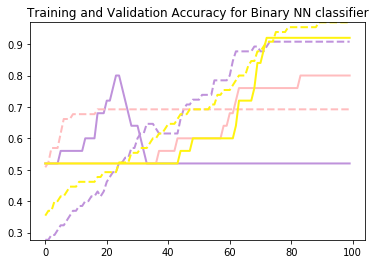

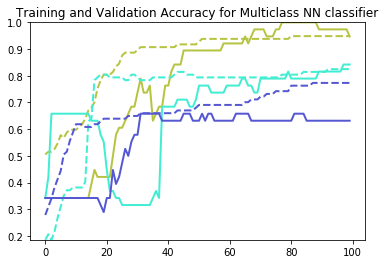

In [6]:
# Show a per epoch training history
def showTrainingHistory(title, histories):
    train_acc = []
    val_acc = []
    for hyper_params, history in histories:
        train_acc.append(history['accuracy'])
        val_acc.append(history['val_accuracy'])

    epoch = range(len(train_acc[0]))
    pb = mm.PlotBuilder()
    if len(train_acc) == 1:
        y_vals = [(train_acc[0], 'Training Accuracy'), (val_acc[0], 'Validation Accuracy')]
        pb.create_plot(title, (epoch, 'epoch'), *y_vals)
    else:
        pb.create_plot(title, (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_acc, val_acc)])
    pb.show()

def model_accuracy(model, data, title):
    print(title)
    predictions, _ = model.predict(data.train_features)
    print("Training accuracy {}".format(mm.Model.accuracy(data.train_target, predictions.ravel())))
    predictions, _ = model.predict(data.validation_features)
    print("Validation accuracy {}".format(mm.Model.accuracy(data.validation_target, predictions.ravel())))
    predictions, _ = model.predict(data.test_features)
    print("Test accuracy {}".format(mm.Model.accuracy(data.test_target, predictions.ravel())))

showTrainingHistory('Training and Validation Accuracy for Binary NN classifier', nnHyperLookup_2.history)
showTrainingHistory('Training and Validation Accuracy for Multiclass NN classifier', nnHyperLookup.history)

#### Best model selection
Select the best model from the hyperparameter space search and retrain the model on the epoch with the highest validation accuracy.

**Please note that because of the re-initialization of the initial parameters the resulting accuracy may differ**

First for the binary classifier:

Binary NN classifier results for {'noFeatures': 4, 'noClasses': 2, 'trainEpochs': 73, 'denseSize': 5, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001675C328F08>} lr=0.0010000000474974513


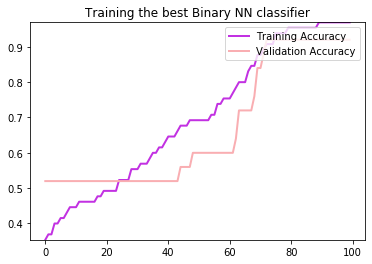

Epoch 1/73
3/3 [==============================] - 1s 449ms/step - loss: 0.6727 - accuracy: 0.4769 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/73
3/3 [==============================] - 0s 70ms/step - loss: 0.6474 - accuracy: 0.4769 - val_loss: 0.7797 - val_accuracy: 0.4800
Epoch 3/73
3/3 [==============================] - 0s 73ms/step - loss: 0.6313 - accuracy: 0.4769 - val_loss: 0.7677 - val_accuracy: 0.4800
Epoch 4/73
3/3 [==============================] - 0s 115ms/step - loss: 0.6159 - accuracy: 0.4769 - val_loss: 0.7574 - val_accuracy: 0.4800
Epoch 5/73
3/3 [==============================] - 0s 67ms/step - loss: 0.6018 - accuracy: 0.4769 - val_loss: 0.7485 - val_accuracy: 0.4800
Epoch 6/73
3/3 [==============================] - 0s 68ms/step - loss: 0.5890 - accuracy: 0.4769 - val_loss: 0.7413 - val_accuracy: 0.4800
Epoch 7/73
3/3 [==============================] - 0s 71ms/step - loss: 0.5773 - accuracy: 0.4769 - val_loss: 0.7353 - val_accuracy: 0.4800
Epoch 8/73
3/3 [=

3/3 [==============================] - 0s 68ms/step - loss: 0.3997 - accuracy: 0.9385 - val_loss: 0.4051 - val_accuracy: 1.0000
Epoch 60/73
3/3 [==============================] - 0s 67ms/step - loss: 0.3982 - accuracy: 0.9385 - val_loss: 0.4016 - val_accuracy: 1.0000
Epoch 61/73
3/3 [==============================] - 0s 68ms/step - loss: 0.3967 - accuracy: 0.9385 - val_loss: 0.3974 - val_accuracy: 1.0000
Epoch 62/73
3/3 [==============================] - 0s 67ms/step - loss: 0.3952 - accuracy: 0.9385 - val_loss: 0.3929 - val_accuracy: 1.0000
Epoch 63/73
3/3 [==============================] - 0s 68ms/step - loss: 0.3938 - accuracy: 0.9385 - val_loss: 0.3904 - val_accuracy: 1.0000
Epoch 64/73
3/3 [==============================] - 0s 122ms/step - loss: 0.3923 - accuracy: 0.9385 - val_loss: 0.3907 - val_accuracy: 1.0000
Epoch 65/73
3/3 [==============================] - 0s 71ms/step - loss: 0.3910 - accuracy: 0.9385 - val_loss: 0.3903 - val_accuracy: 1.0000
Epoch 66/73
3/3 [==============

In [16]:
# Select the best model for the binary NN
print("Binary NN classifier results for {} lr={}".format(nnHyperLookup_2.best_params,
                                                         tf.keras.backend.eval(nnHyperLookup_2.best_params['optimizer'].lr)))
showTrainingHistory('Training the best Binary NN classifier', [(nnHyperLookup_2.best_params, nnHyperLookup_2.best_history)])
# retrain the model on the best epoch
nnHyperLookup_2.best_params['trainEpochs'] = np.argmax(nnHyperLookup_2.best_history['val_accuracy']) + 1
best_nn_model_2 = NNModel(**nnHyperLookup_2.best_params)
_ = best_nn_model_2.train(data_model_2)

Then for the multiclass classifier:

Multiclass NN classifier results for {'noFeatures': 4, 'noClasses': 3, 'trainEpochs': 78, 'denseSize': 5, 'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000001675BBC31C8>} lr=0.0010000000474974513


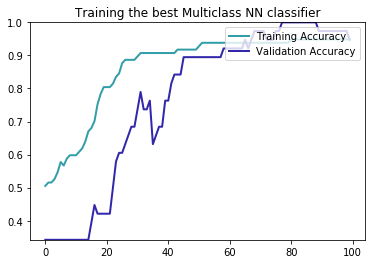

Epoch 1/78
4/4 [==============================] - 2s 410ms/step - loss: 0.9724 - accuracy: 0.6598 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/78
4/4 [==============================] - 0s 58ms/step - loss: 0.9057 - accuracy: 0.6907 - val_loss: 2.5734 - val_accuracy: 0.4474
Epoch 3/78
4/4 [==============================] - 0s 58ms/step - loss: 0.8907 - accuracy: 0.7010 - val_loss: 2.5195 - val_accuracy: 0.4211
Epoch 4/78
4/4 [==============================] - 0s 57ms/step - loss: 0.8780 - accuracy: 0.7010 - val_loss: 2.4721 - val_accuracy: 0.3947
Epoch 5/78
4/4 [==============================] - 0s 57ms/step - loss: 0.8670 - accuracy: 0.7010 - val_loss: 2.4248 - val_accuracy: 0.3421
Epoch 6/78
4/4 [==============================] - 0s 57ms/step - loss: 0.8570 - accuracy: 0.7216 - val_loss: 2.3810 - val_accuracy: 0.2632
Epoch 7/78
4/4 [==============================] - 0s 56ms/step - loss: 0.8474 - accuracy: 0.7320 - val_loss: 2.3379 - val_accuracy: 0.1579
Epoch 8/78
4/4 [==

4/4 [==============================] - 0s 55ms/step - loss: 0.5942 - accuracy: 0.9588 - val_loss: 0.6391 - val_accuracy: 0.8421
Epoch 60/78
4/4 [==============================] - 0s 54ms/step - loss: 0.5909 - accuracy: 0.9691 - val_loss: 0.6264 - val_accuracy: 0.8421
Epoch 61/78
4/4 [==============================] - 0s 58ms/step - loss: 0.5875 - accuracy: 0.9794 - val_loss: 0.6135 - val_accuracy: 0.8421
Epoch 62/78
4/4 [==============================] - 0s 56ms/step - loss: 0.5842 - accuracy: 0.9794 - val_loss: 0.6022 - val_accuracy: 0.8421
Epoch 63/78
4/4 [==============================] - 0s 56ms/step - loss: 0.5810 - accuracy: 0.9794 - val_loss: 0.5914 - val_accuracy: 0.8421
Epoch 64/78
4/4 [==============================] - 0s 54ms/step - loss: 0.5777 - accuracy: 0.9794 - val_loss: 0.5826 - val_accuracy: 0.8421
Epoch 65/78
4/4 [==============================] - 0s 56ms/step - loss: 0.5746 - accuracy: 0.9794 - val_loss: 0.5733 - val_accuracy: 0.8421
Epoch 66/78
4/4 [===============

In [17]:
# Select the best model for the binary NN
print("Multiclass NN classifier results for {} lr={}".format(nnHyperLookup.best_params,
                                                             tf.keras.backend.eval(nnHyperLookup.best_params['optimizer'].lr)))
showTrainingHistory('Training the best Multiclass NN classifier', [(nnHyperLookup.best_params, nnHyperLookup.best_history)])
# retrain the model on the best epoch
nnHyperLookup.best_params['trainEpochs'] = np.argmax(nnHyperLookup.best_history['val_accuracy']) + 1
best_nn_model = NNModel(**nnHyperLookup.best_params)
_ = best_nn_model.train(data_model)

In [18]:
# binary classification
model_accuracy(best_nn_model_2, data_model_2, '=========NN Binary classification=========')
# multi-class classification
model_accuracy(best_nn_model, data_model, '=========NN Multiclass classification=======')

=========NN Binary classification=========
Training accuracy 0.9846153846153847
Validation accuracy 1.0
Test accuracy 0.9
=========NN Multiclass classification=======
Training accuracy 0.9381443298969072
Validation accuracy 0.9736842105263158
Test accuracy 0.8666666666666667


### Bayesian Neural Network
Build a bayesian neural network using just tensor flow proabability (**no Edward2 wich is actually not part of TFP**)

Though one could use the variational layers that tfp.layers module offers, such as the tfp.layers.DenseFlipout layer to implement a hidden dense layer with weights and biasses using a normal distribution I wanted to get my hands dirty and implement the bayesian neural network manually.

The modelling aproach in Tensor Flow Probability is very similar to a PYMC or Edward2 implementation (once you finally undestand it - and hope you did so correctly).

You first define a graph of independent distributions (with their underlying connections). The difference is, apart from the PYMC, is that you have to manually define your joint log probability function of the observed data and your loss and then fit that into an optimizer that can do the gradient descent magic.

The above applies for computing the MAP or using variational inference for a model. For MCMC you just have to use the above log probability function and do a sample.

In order not to manually add all the weights and biasses and have a more structured way of computing the log probability I used the new TFP distributions.JointDistributionSequential class (**it is proabable the first example around on how to use this tfp class to implement a bayesian neural network**). It is very similar with a Keras Sequencial approach.

In order to run a gradient descent or a MCMC sample we need the keep track of the current state, the state that is being used to generate the log likelyhood. I do this in **get_initial_state** function where the state of each distribution is a tf.Variable and the state of the observed target class is a tf.constant.

Implementation notes:
* The model follows the mm.Model class architecture
* To predict a new data I compute the mean of the samples or the value resulted in a trained optization process
* The model is also initialized by passing a dictionary of hyperparameters
* To do prediction we use the trained distributions (either with MAP, MCMC, VI) but we dont feed the resulted probabilities into the last bayesian layer (categorical or binomial) but instead do a normal argmax prediction

**The model below implemets computing the MAP of a bayesian neural network**

In [19]:
from functools import partial
import tensorflow_probability as tfp

class BayesNNModel(mm.TensorModel):

    def __init__(self, **hyper_params):
        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # Python like bind
        model = partial(self.build_model, hyper_params)
        self._model_prototype = model
        super(BayesNNModel, self).__init__(model, checkpoint=False)

    def _nn_model(self, X, model_parameters):
        """The standard 3 layer NN network"""
        Wd1, Bd1, Wd2, Bd2, Wd3, Bd3 = model_parameters
        # Set the last activation to be sigmoid or softmax depending if there is a binary classification
        last_activation = tf.nn.sigmoid if Bd3.shape[-1] == 1 else tf.nn.softmax

        def dense_layer(W, B, activation=tf.nn.relu):
            """Forward pass through a dense layer"""
            def wrapped_func(func):
                def wrapped_args(*args, **kwargs):
                    return activation(tf.matmul(func(*args, **kwargs), W) + B)
                return wrapped_args
            return wrapped_func

        @tf.function
        @dense_layer(Wd3, Bd3, activation=last_activation)
        @dense_layer(Wd2, Bd2)
        @dense_layer(Wd1, Bd1)
        def compute(X):
            return X

        return compute(X)

    def build_model(self, hyper_params, X):
        """Build the Bayes NN using only tensorflow probability distributions"""
        feature_size = hyper_params.get('noFeatures', 4)
        dense_size = hyper_params.get('denseSize', 10)
        no_classes = hyper_params.get('noClasses', len(data_model.classes))
        if no_classes == 2:
            no_classes = 1
        self._no_classes = no_classes
        # Build the joint distribution of the NN
        model = tfp.distributions.JointDistributionSequential([
            # First dense Layer parameters
            tfp.distributions.Normal(loc=tf.zeros([feature_size, dense_size]),
                                     scale=tf.ones([feature_size, dense_size])),                     # Wd1
            tfp.distributions.Normal(loc=tf.zeros([1, dense_size]), scale=tf.ones([1, dense_size])), # Bd1
            # Second dense Layer parameters
            tfp.distributions.Normal(loc=tf.zeros([dense_size, dense_size]),
                                     scale=tf.ones([dense_size, dense_size])),                       # Wd2
            tfp.distributions.Normal(loc=tf.zeros([1, dense_size]), scale=tf.ones([1, dense_size])), # Bd2
            # Last layer parameters
            tfp.distributions.Normal(loc=tf.zeros([dense_size, no_classes]),
                                    scale=tf.ones([dense_size, no_classes])),                        # Wd3
            tfp.distributions.Normal(loc=tf.zeros([1, no_classes]), scale=tf.ones([1, no_classes])), # Bd3
            # Output likelyhood
            lambda Bd3, Wd3, Bd2, Wd2, Bd1, Wd1:
                tfp.distributions.Bernoulli(probs=self._nn_model(X, [Wd1, Bd1, Wd2, Bd2, Wd3, Bd3]))
                        if no_classes == 1 else
                tfp.distributions.Categorical(probs=self._nn_model(X, [Wd1, Bd1, Wd2, Bd2, Wd3, Bd3]))
        ])
        return model
    
    def model_log_prob(self, state):
        # The state is the list of current distribution values with target at the last
        # all returned distributions log probilities of the current state are indendent
        distributions = self._model.log_prob_parts(state)
        
        prob = 0
        # this means that we can simply sum (because of log) over them
        for dist in distributions:
            prob += tf.reduce_sum(dist, axis=None)

        return prob
    
    def get_initial_state(self, target):
        distributions = self._model.sample()
        # The last distribution is the output so remove it to add the observed output
        distributions.pop()
        distributions = [tf.Variable(dist) for dist in distributions]
        distributions.append(tf.constant(target))
        return distributions

    def _MAP(self, initial_state):
        """Maximum a posteriori estimation"""
        def loss():
            return -self.model_log_prob(initial_state)
        
        @tf.function
        def minimize():
            """Add this to TF2.0 AutoGraph to improve performance"""
            self._optimizer.minimize(loss, var_list=initial_state[:-1])
        
        for epoch in range(self._train_epochs):
            minimize()
        return initial_state[:-1]

    def train(self, data_model):
        train_x = tf.convert_to_tensor(data_model.train_features, dtype=tf.float32)

        has_nan = True
        while has_nan:
            # Compute the joint distribution NN over the training data
            self._model = self._model_prototype(train_x)

            if self._no_classes == 1:
                train_y = tf.convert_to_tensor([[t] for t in data_model.train_target], dtype=tf.int32)
            else:
                train_y = tf.convert_to_tensor(data_model.train_target, dtype=tf.int32)
            # Get the initial state
            initial_state = self.get_initial_state(train_y)

            # Run the MAP
            distributions = self._MAP(initial_state)
            self._trained_distributions = distributions

            has_nan = False
            for dist in distributions:
                has_nan |= np.isnan(dist.numpy()).any()

        return distributions
    
    @property
    def trained_distributions(self):
        return self._trained_distributions.copy()

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        predictions = self._nn_model(features_ds, self._trained_distributions)
        if predictions.shape[-1] == 1:
            # binary classification
            prediction_classes = (predictions.numpy().ravel() > 0.5).astype(int)
        else:
            prediction_classes = np.argmax(predictions, axis=1)
        return prediction_classes, predictions

#### Maximum A Posteriori distribution
Compute the MAP of the Bayesian model.

Check the resulted accuracy and save the distributions.

In [20]:
# binary classification
_M['MAP_2C'] = BayesNNModel(denseSize=5, trainEpochs=2000, noClasses=2)
_M['MAP_2C'].train(data_model_2)
model_accuracy(_M['MAP_2C'], data_model_2, '=========Bayes NN Binary classification Maximum A Posteriori estimation=========')
# multi-class classification
_M['MAP_MC'] = BayesNNModel(denseSize=5, trainEpochs=2000)
_M['MAP_MC'].train(data_model)
model_accuracy(_M['MAP_MC'], data_model, '=========Bayes NN Multiclass classification Maximum A Posteriori estimation=========')

=========Bayes NN Binary classification Maximum A Posteriori estimation=========
Training accuracy 0.9846153846153847
Validation accuracy 1.0
Test accuracy 0.8
=========Bayes NN Multiclass classification Maximum A Posteriori estimation=========
Training accuracy 0.9896907216494846
Validation accuracy 1.0
Test accuracy 0.8666666666666667


#### MCMC Model
Create a Bayesian NN Model using MCMC sampling.

Implementation notes:
* The same joint log probability distribution is used as in MAP
* The initial state is the one saved from running MAP above to limit the amount of sampling required for the chains to converge
* There are 2 types of MCMC sampling that you can use: Metropolis Hastings (same as in PYMC - hopefully) or Hamiltonian Monte Carlo that takes a series of gradient-informed steps to produce a Metropolis proposal.
* The model is also configure through passing hyperparameters such as the burninEpochs - number of burnin samples. trainEpochs is the number of MCMC samples after burnin

In [21]:
class MCMCBayesNNModel(BayesNNModel):

    def __init__(self, **hyper_params):
        super(MCMCBayesNNModel, self).__init__(**hyper_params)

        self._burnin_epochs = hyper_params.get('burninEpochs', int(self._train_epochs / 3))
        self._mcmc_kernel = hyper_params.get('mcmcKernel', None)
        self._mcmc_kernel_type = hyper_params.get('mcmcKernelType', None)
        self._mcmc_params = hyper_params.get('mcmcParams', {})
        self._mcmc_intial_state = hyper_params.get('mcmcMAP', None)
    
    def mcmc_log_prob(self, target, *args):
        # The state is the list of current distribution values with target at the last
        state = list(args)
        state.append(target)

        return self.model_log_prob(state)
    
    def _MCMC(self, initial_state):
        @tf.function
        def sample_mcmc(*args, **kwargs):
            """Add this to TF2.0 AutoGraph to improve performance"""
            return tfp.mcmc.sample_chain(*args, **kwargs)

        log_prob_fn = partial(self.mcmc_log_prob, initial_state[-1])
        initial_state = initial_state[:-1]
        
        if self._mcmc_kernel is None:
            if self._mcmc_kernel_type == 'metropolis':
                self._mcmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                    tfp.mcmc.MetropolisHastings(
                        tfp.mcmc.UncalibratedHamiltonianMonteCarlo(log_prob_fn, **self._mcmc_params)),
                    num_adaptation_steps=int(self._burnin_epochs * 0.8))
            else:
                self._mcmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                    tfp.mcmc.HamiltonianMonteCarlo(log_prob_fn, **self._mcmc_params),
                    num_adaptation_steps=int(self._burnin_epochs * 0.8))

        return sample_mcmc(kernel=self._mcmc_kernel,
                           current_state=initial_state,
                           previous_kernel_results=self._mcmc_kernel.bootstrap_results(initial_state),
                           num_burnin_steps=self._burnin_epochs,
                           num_results=self._train_epochs,
                           trace_fn=None,
                           return_final_kernel_results=False)

    def train(self, data_model):
        train_x = tf.convert_to_tensor(data_model.train_features, dtype=tf.float32)

        # Compute the joint distribution NN over the training data
        self._model = self._model_prototype(train_x)

        if self._no_classes == 1:
            train_y = tf.convert_to_tensor([[t] for t in data_model.train_target], dtype=tf.int32)
        else:
            train_y = tf.convert_to_tensor(data_model.train_target, dtype=tf.int32)
        
        
        # Get the initial state
        if self._mcmc_intial_state is None:
            initial_state = self.get_initial_state(train_y)
        else:
            initial_state = self._mcmc_intial_state.copy()
            initial_state.append(tf.constant(train_y))

        # Run the MCMC
        distributions = self._MCMC(initial_state)
        # Each distribution is a tensor of shape (samples=noEpochs, ...)
        # We get the expectation of each distribution as a mean of all epochs (samples)
        self._trained_distributions = [tf.reduce_mean(dist, axis=0) for dist in distributions]

        return distributions

#### MCMC results
Test the MCMC results for both the binary and the multiclass classification

Use MAP to limit the amount of samples

In [25]:
# binary classification
_M['MCMC_2C'] = MCMCBayesNNModel(denseSize=5, noClasses=2, trainEpochs=3000, burninEpochs=2000,
                                 mcmcMAP=_M['MAP_2C'].trained_distributions, # take the MAP computed above
                                 mcmcParams={'step_size' : 0.3, 'num_leapfrog_steps' : 2, 'state_gradients_are_stopped' : True})
_M['MCMC_2C.distributions'] = _M['MCMC_2C'].train(data_model_2)
model_accuracy(_M['MCMC_2C'], data_model_2, '=========Bayes NN Binary classification MCMC estimation=========')
# multi-class classification
_M['MCMC_MC'] = MCMCBayesNNModel(denseSize=5, trainEpochs=3000, burninEpochs=2000,
                                 mcmcMAP=_M['MAP_MC'].trained_distributions, # take the MAP computed above
                                 mcmcParams={'step_size' : 0.3, 'num_leapfrog_steps' : 2, 'state_gradients_are_stopped' : True})
_M['MCMC_MC.distributions'] = _M['MCMC_MC'].train(data_model)
model_accuracy(_M['MCMC_MC'], data_model, '=========Bayes NN Multiclass classification MCMC estimation========')

=========Bayes NN Binary classification MCMC estimation=========
Training accuracy 0.9076923076923077
Validation accuracy 0.92
Test accuracy 0.7
=========Bayes NN Multiclass classification MCMC estimation========
Training accuracy 0.9690721649484536
Validation accuracy 0.9736842105263158
Test accuracy 0.8666666666666667


#### Plot the model's distributions
Using arviz package I am plotting the weights and the biasses distribution for each layer

First for the **binary classifier**

=========Bayes NN Binary classification MCMC distributions=========


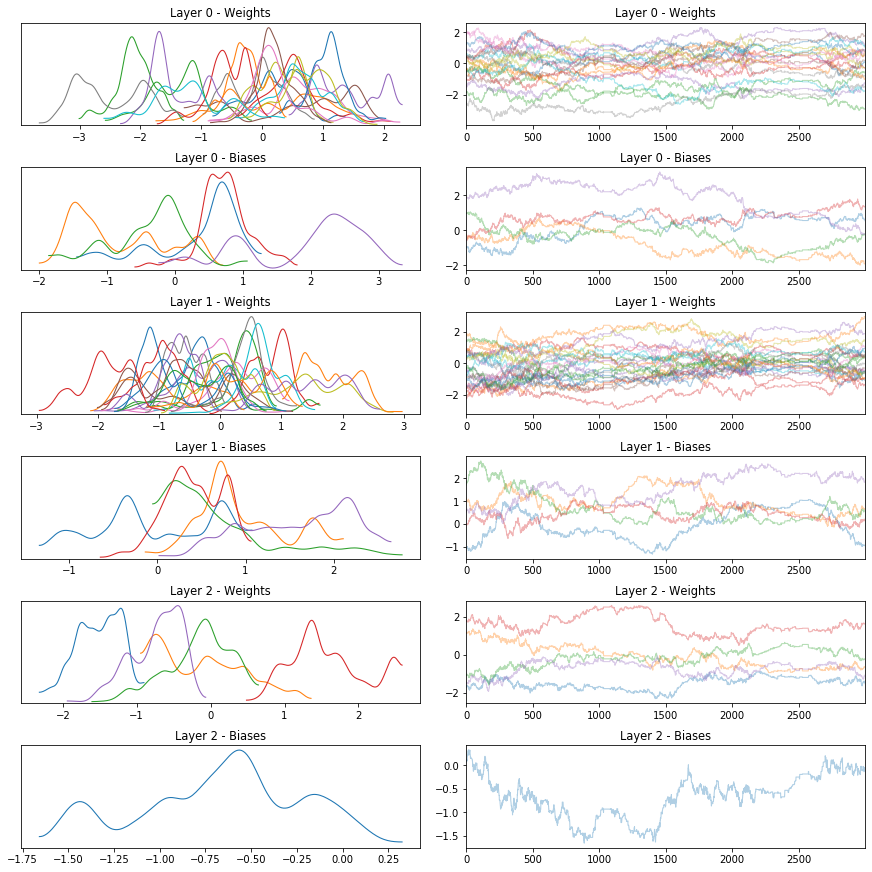

In [26]:
def plot_nn_distributions(nn_samples):
    import arviz as az
    import warnings
    warnings.filterwarnings("ignore")

    no_layers = int(len(nn_samples) / 2)
    # Make a list of [no_samples x no_dist] arrays for the weights and biases of each layer
    nn_samples = [dist.numpy().reshape(dist.shape[0], np.prod(dist.shape[1:])) for dist in nn_samples]
    # Swap axes on each array to have [no_dist x no_samples]
    nn_samples = [np.swapaxes(dist, 1, 0) for dist in nn_samples]

    layer_names = ['Layer {} - {}'.format(int(i/2), 'Weights' if i%2==0 else 'Biases') for i in range(2*no_layers)]
    az.plot_trace(az.from_dict(posterior={k:v for k, v in zip(layer_names, nn_samples)}));

print('=========Bayes NN Binary classification MCMC distributions=========')
plot_nn_distributions(_M['MCMC_2C.distributions'])

Now for the **multiclass classifier**

=========Bayes NN Multiclass classification MCMC estimation========


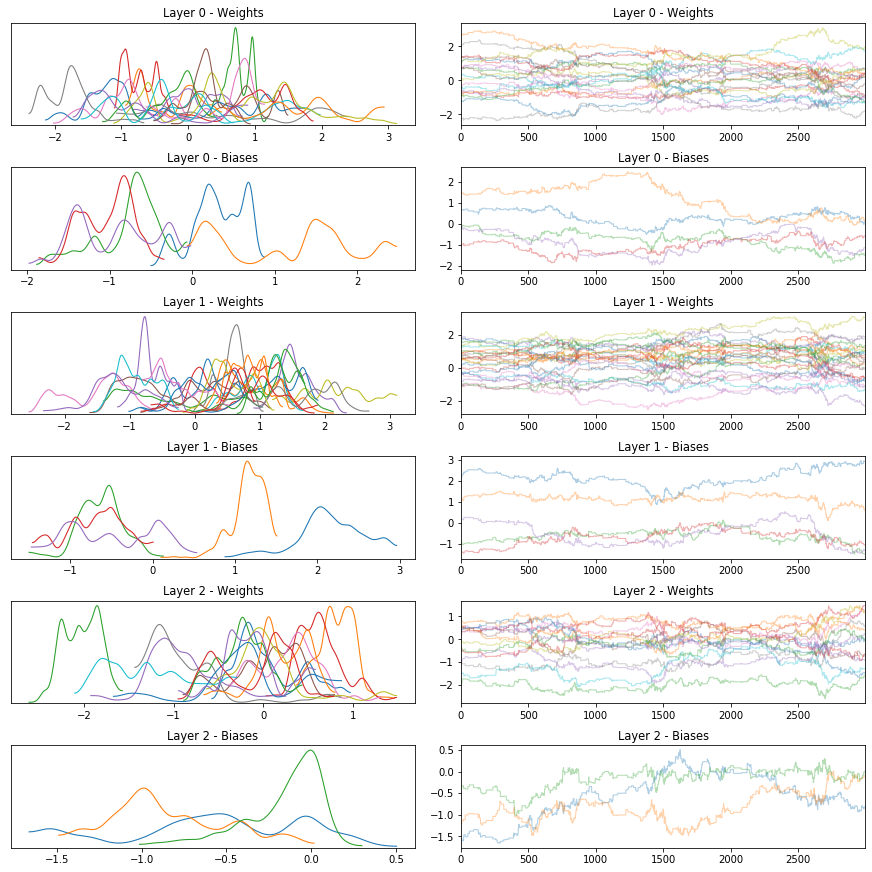

In [27]:
print('=========Bayes NN Multiclass classification MCMC estimation========')
plot_nn_distributions(_M['MCMC_MC.distributions'])

#### Variational Inference
Create the model again and optimize it using variational inference.

To use VI to train a bayes NN model now we need to assume a posterior distribution for each weight and bias. Since we are already using a Normal distribution for them we can also assume that the posterior distribution is also a Normal.

Hence if we were do make a manual VI bayes neural net for each Normal distribution of each weight and bias we add 2 new tf.Variable trainable parameters, the mean and standard deviation of the distribution. In Variational Inference this 2 new parameters will be tried to be optimized in order for the posterior Normal(tf.Variable(mean), tf.Variable(std)) to best aproximate the posterior.

To achive that and use a tensorflow optimizer we need to define a loss, which for VI is called ELBO (evidence lower bound). It is usually defined as the KL divergence between the current posterior distribution and the prior minor the log likelihood of the target classification.

To implement VI in Bayesian Neural Network I chose to use the Keras tensorflow probability DenseFlipout layer. Paper: https://arxiv.org/abs/1803.04386

The posterior for each weight is defined as tfp.layers.default_mean_field_normal_fn which assings a Normal(0, 0.1) to each trainable parameter. I force the same distribution to the biasses as well.

Implementation notes:
* ELBO is computed as the Keras layer's losses attribute - the log likelihood of the target classes. The losses attribute is computed internally by the DenseFlipout layer as the KL divergence between the posterior and the prior of all weights and biasses.
* The keras model trainable_parameters gets the list of all tf.Variables in all layers, representing the mean and stds of each weight and bias, to be fed into the optimizer
* The distribution of the trained weights and biasses are obtained in the _sample_layers_distributions method that will sample from the trained distribution. Since the distribution parameters are its mean and std I am currently sampling from W01 ~ Normal(trained_vi_mean, trained_vi_std)
* The class predictions are computed as usual using the trained distributions of the Keras layers and applying argmax on the resulted probability as in a normal neural network.

In [28]:
class VIBayesNNModel(mm.TensorModel):

    def __init__(self, **hyper_params):
        """Build the Bayes NN using only tensorflow probability distributions"""
        """Here we are tring to aproximate the weights and biases with a normal using VI"""
        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())
        self._no_classes = hyper_params.get('noClasses', len(data_model.classes))
        if self._no_classes == 2:
            self._no_classes = 1

        super(VIBayesNNModel, self).__init__(self.build_model(hyper_params), checkpoint=False)
    
    def build_model(self, hyper_params):
        """Build a VI Bayes NN using Keras layers"""
        feature_size = hyper_params.get('noFeatures', 4)
        dense_size = hyper_params.get('denseSize', 10)
        
        model = tf.keras.Sequential([
            tfp.layers.DenseFlipout(hyper_params.get('denseSize', 10),
                                    input_shape=(hyper_params.get('noFeatures', 4),),
                                    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(), name="Layer_0"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tfp.layers.DenseFlipout(hyper_params.get('denseSize', 10),
                                    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(), name="Layer_1"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tfp.layers.DenseFlipout(self._no_classes,
                                    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(), name="Layer_2"),
            tf.keras.layers.Activation('softmax', name='softmax')
               if self._no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ])
        
        return model

    def predictions(self, X):
        predictions = tfp.distributions.Bernoulli(probs=self._model(X)) \
                           if self._no_classes == 1 else \
                      tfp.distributions.Categorical(probs=self._model(X))

        return predictions
    
    def _sample_layers_distributions(self, no_samples):
        """Sample from the trained distribution of each layer"""
        sample_dist = []
        for layer in self._model.layers:
            try:
                # weights
                dist = layer.kernel_posterior
                sample_dist.append(dist.sample(no_samples))
                # biases
                dist = layer.bias_posterior
                sample_dist.append(dist.sample(no_samples))
            except AttributeError:
              pass
        return sample_dist

    def _VI(self, X, Y):
        def elbo_loss():
            """Evidence lower bound loss"""
            # ELBO = KL - log_prob(likelihood)
            log_likelihood = tf.reduce_mean(self.predictions(X).log_prob(Y))
            kl = sum(self._model.losses) / len(Y)

            elbo = kl - log_likelihood
            return elbo
    
        @tf.function
        def minimize():
            """Add this to TF2.0 AutoGraph to improve performance"""
            self._optimizer.minimize(elbo_loss, var_list=self._model.trainable_variables)
    
        for epoch in range(self._train_epochs):
            minimize()

    def train(self, data_model):
        train_x = tf.convert_to_tensor(data_model.train_features, dtype=tf.float32)
        if self._no_classes == 1:
            train_y = tf.convert_to_tensor([[t] for t in data_model.train_target], dtype=tf.int32)
        else:
            train_y = tf.convert_to_tensor(data_model.train_target, dtype=tf.int32)
    
        # Run the VI
        self._VI(train_x, train_y)

        # return the sampled distribution from the dense layers
        return self._sample_layers_distributions(self._train_epochs)

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        predictions = self._model(features_ds)
        if predictions.shape[-1] == 1:
            # binary classification
            prediction_classes = (predictions.numpy().ravel() > 0.5).astype(int)
        else:
            prediction_classes = np.argmax(predictions, axis=1)
        return prediction_classes, predictions

# Print the summary of the model used for multiclass classification
VIBayesNNModel(noFeatures=4, noClasses=3, denseSize=5)._model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_0 (DenseFlipout)       (None, 5)                 50        
_________________________________________________________________
batch_normalization_6 (Batch (None, 5)                 20        
_________________________________________________________________
activation_6 (Activation)    (None, 5)                 0         
_________________________________________________________________
Layer_1 (DenseFlipout)       (None, 5)                 60        
_________________________________________________________________
batch_normalization_7 (Batch (None, 5)                 20        
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
_______________________________________________

#### VI BNN results
Train and test both the binary and multiclass classification using Variational Inference

Save the trained weights and biasses distribution samples.

As before plot the the distributions for both models

In [ ]:
# binary classification
_M['VI_2C'] = VIBayesNNModel(denseSize=5, trainEpochs=2000, noClasses=2)
_M['VI_2C.distributions'] = _M['VI_2C'].train(data_model_2)
model_accuracy(_M['VI_2C'], data_model_2, '=========Bayes NN Binary classification Variational Inference estimation=========')
# multi-class classification
_M['VI_MC'] = VIBayesNNModel(denseSize=5, trainEpochs=2000, noClasses=3)
_M['VI_MC.distributions'] = _M['VI_MC'].train(data_model)
model_accuracy(_M['VI_MC'], data_model, '=========Bayes NN Multiclass classification Variational Inference estimation=========')

=========Bayes NN Binary classification Variational Inference estimation=========
Training accuracy 0.8461538461538461
Validation accuracy 1.0
Test accuracy 0.8


In [ ]:
print('=========Bayes NN Binary classification Variational Inference distributions=========')
plot_nn_distributions(_M['VI_2C.distributions'])

In [ ]:
print('=========Bayes NN Multiclass classification Variational Inference distributions=========')
plot_nn_distributions(_M['VI_MC.distributions'])

### Probability of the resulted prediction

To compute the probability of the predicted result of a Bayesian Neural Network we can the following

$P(test | train) = \int_{model} P(test | model) * P(model | train) \cong \frac{1}{N} * \sum_{i=1}^N P(test | model_i) $
were model_i is a sample of the posterior of the P(model | train)

In [ ]:
def compute_predict_prob(model, features, no_samples):
    """Compute the probability of the predictions from the Bernouli or Categorical distribution
    averaged against multiple predictions sampled from the posterior distribution of the trained model"""
    features = tf.cast(features, tf.float32)
    probs = np.asarray([model.predictions(features).probs for _ in range(no_samples)])
    probs = np.mean(probs, axis=0)
    if probs.shape[-1] == 1:
        # For binary classification and the probability of the 0 class
        probs = np.column_stack(( np.ones(len(probs)), probs ))
        probs[:, 0] = probs[:,0] - probs[:, 1]
    target_class, _ = model.predict(features)
    return target_class, probs

def print_predict_prob(model, features, title):
    predicted, prob = compute_predict_prob(model, features, 100)
    prob = [prob[i, predicted[i]] for i in range(len(predicted))]
    print("{}\nPredicted class:{}\nPredicted Probability:{}".format(title, predicted, prob))

print_predict_prob(_M['VI_2C'], data_model_2.test_features, 'VI BayesNN Binary classifier')
print_predict_prob(_M['VI_MC'], data_model.test_features, 'VI BayesNN Multiclass classifier')

### Credible interval
Sometimes, expecially in regression tasks, one takes into account the confidence interval of a prediction. Though this is a frequentist term for a bayesian model the credible interval should be a more appropiate term.

Given a sampled distribution of probabilities of a target classification we can check what is the pertange that lie in that interval. For example to get the percentage of the samples that lie in the 95% credible interval we can do the following:
* compute alpha = (1 - credible_interval) / 2
* given the distribution of sampled prediction, count the samples that lie between (alpha, 1-alpha) percentile
* divide count by the total number of samples

I also compute for each predicted class the probability interval of the last layer under the credible interval.

In [ ]:
def credible_percentage(model, features, credible_interval, no_samples, title):
    """Compute the probability of the predictions from the Bernouli or Categorical distribution of the trained model"""
    alpha = (1 - credible_interval) / 2

    features = tf.cast(features, tf.float32)
    # probs no_samples x len(data_size) x no_classes
    probs = np.asarray([model.predictions(features).probs for _ in range(no_samples)])
    # probs len(data_size) x no_samples x no_classes
    probs = np.swapaxes(probs, 1, 0)

    predicted, _ = model.predict(features)    
    di = []
    ci = []
    for i in range(len(predicted)):
        samples_di = probs[i]
        if samples_di.shape[-1] == 1:
            # For binary classification and the probability of the 0 class
            samples_di = np.column_stack(( np.ones(len(samples_di)), samples_di ))
            samples_di[:, 0] = samples_di[:,0] - samples_di[:, 1]
        
        samples_di = samples_di[:, predicted[i]]
        q1 = np.percentile(samples_di, alpha * 100, axis=0)
        q2 = np.percentile(samples_di, (1-alpha) * 100 , axis=0)
        di.append(sum(np.logical_and(samples_di >= q1, samples_di <= q2)) / no_samples)
        ci.append((q1, q2))

    print(title)
    print("Predicted class  Sample percentage in {}% CI  Probability interval of the prediction".format(int(credible_interval*100)))
    for i in range(len(predicted)):
        print("{:>10}{:>20}\t\t\t{}".format(predicted[i], di[i], list(ci[i])))

credible_percentage(_M['VI_2C'], data_model_2.test_features, 0.95, 200, 'VI BayesNN Binary classifier')
credible_percentage(_M['VI_2C'], data_model_2.test_features, 0.6, 200, 'VI BayesNN Binary classifier')
credible_percentage(_M['VI_MC'], data_model.test_features, 0.95, 200, 'VI BayesNN Multiclass classifier')
credible_percentage(_M['VI_MC'], data_model.test_features, 0.6, 200, 'VI BayesNN Multiclass classifier')